In [620]:
from matplotlib import pyplot as plt
from systemclass import SNAIL,SNAIL_sweep,Cavity, SNAILC, SNAILC_sweep, SNAILCC, SNAILCC_sweep
import numpy as np
from joblib import Parallel, delayed

In [621]:
def sort(energies,U,H):
    diagonal_elements = np.diag(H)

    # Find the index of the closest diagonal element for each eigenvalue
    closest_indices = np.argmin(abs(energies[:, np.newaxis] - diagonal_elements), axis=1)

    # Sort energies and U according to the indices of closest diagonal elements
    sorted_energies = energies[np.argsort(closest_indices)]
    U = U[:, np.argsort(closest_indices)]
    return sorted_energies,U

In [622]:
def calculate_overlap(state1, state2):
    return abs((state1.dag() * state2)[0,0])**2
def find_optimal_k(A, B, D):
    # Define a large initial minimum difference
    min_diff = float('inf')
    optimal_k = None
    
    # Iterate over a range of possible k values
    # The range can be adjusted based on expected size of k or other insights you have about your problem
    for k in range(-1000, 1000):
        # Calculate the difference for this value of k
        diff = abs(A - (B + k * D))
        
        # If this is the smallest difference we've found so far, update min_diff and optimal_k
        if diff < min_diff:
            min_diff = diff
            optimal_k = k
            
    return optimal_k
def T1f(der):
    factor = np.sqrt(2*np.abs(np.log(2*np.pi*1*1e-5)))
    return np.abs(1/(factor*10**-6*der))

In [623]:
omega_c1 = 4.1*2*np.pi
g_int1 = 0.15/2*1.9*2*np.pi
omega_c2 = 5.3*2*np.pi
g_int2 =0.15/2*0.7*2*np.pi

In [624]:
from qutip import propagator,floquet_modes,Qobj,Options,basis
def energy_diff(A,omega,flux):
    #snail parameters
    EJ = 100*2*np.pi
    EC = 0.177*2*np.pi
    beta = 0.12
    ng = 0
    ncut = 300
    N = 3
    dims = 10
    snail = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)
    omegas = snail.omegas
    
    #cavity1 parameters
    
    
    dimc1 = 5
    cavity1 = Cavity(omega_c1,g_int1,dimc1)
    
    #cavity1 parameters

    dimc2 = 5
    cavity2 = Cavity(omega_c2,g_int2,dimc2)
    snailcc = SNAILCC(snail,cavity1,cavity2)
    
    H0,Hc = snailcc.hamiltonian()
    energy,U = np.linalg.eigh(H0)
    U_dag = np.transpose(U.conjugate())
    Hc = U_dag @ Hc @ U
    H0 = U_dag @ H0 @ U
    H0 = H0 - H0[0][0]*np.identity(len(H0))
    indexc11 = np.argmin(np.abs(energy - omega_c1 * np.ones(len(energy))))
    indexc21 = np.argmin(np.abs(energy - omega_c2 * np.ones(len(energy))))
    index12 = np.argmin(np.abs(energy - omega_c2 * np.ones(len(energy)) - omega_c1 * np.ones(len(energy))))
    indexs1 = np.argmin(np.abs(energy - omegas * np.ones(len(energy))))
    indexsc1 = np.argmin(np.abs(energy - (omegas+omega_c1) * np.ones(len(energy))))
    indexsc2 = np.argmin(np.abs(energy - (omegas+omega_c2) * np.ones(len(energy))))
    indexc12 = np.argmin(np.abs(energy - 2 * omega_c1 * np.ones(len(energy))))
    indexc22 = np.argmin(np.abs(energy - 2 * omega_c2 * np.ones(len(energy))))
    H0 = Qobj(H0)
    Hc = Qobj(Hc)
    args = {'w': omega}
    T = 2*np.pi/omega
#     H = [H0, [Hc, lambda t, args: A*np.cos(args['w']*t)]] 
    H = [H0, [Hc, lambda t, args: A*np.cos(args['w']*t)]] 
    options = Options(nsteps=1000000)  # Increasing nsteps to 10000, adjust as needed
    f_modes, f_energies = floquet_modes(H, T, args, False, options=options) 
    total_dim = dims*dimc1*dimc2
    basis_states = [basis(total_dim, 0),basis(total_dim, indexc11), basis(total_dim, indexc21),basis(total_dim, index12),
                   basis(total_dim, indexs1),basis(total_dim, indexsc1),basis(total_dim, indexsc2),
                   basis(total_dim, indexc12),basis(total_dim, indexc22)]
    
    
    max_overlap_indices = [0,0,0,0,0,0,0,0,0]
    max_overlaps = [0,0,0,0,0,0,0,0,0]

    for f_index, f_state in enumerate(f_modes):

        # Loop over each basis state
        for b_index, b_state in enumerate(basis_states):

            # Calculate the overlap
            overlap = calculate_overlap(f_state, b_state)

            # If this is the maximum overlap for this basis state, store the index
            if overlap > max_overlaps[b_index]:
                max_overlaps[b_index] = overlap
                max_overlap_indices[b_index] = f_index
    energyg = f_energies[max_overlap_indices[0]]/2/np.pi
    omega = 2*np.pi/T

    energyc1p = f_energies[max_overlap_indices[1]]/2/np.pi
    k = find_optimal_k(omega_c1/2/np.pi, energyc1p , omega/2/np.pi)
    energyc1p = energyc1p + k *omega/2/np.pi - energyg
    energyc2p = f_energies[max_overlap_indices[2]]/2/np.pi
    k = find_optimal_k(omega_c2/2/np.pi, energyc2p, omega/2/np.pi)
    energyc2p = energyc2p + k *omega/2/np.pi - energyg
    
    omega12 = f_energies[max_overlap_indices[3]]/2/np.pi
    k = find_optimal_k(omega_c1/2/np.pi+omega_c2/2/np.pi, omega12 , omega/2/np.pi)
    omega12 = omega12 +k *omega/2/np.pi - energyg
    
    diff = omega12 - energyc1p - energyc2p
    
    energys1 = f_energies[max_overlap_indices[4]]/2/np.pi
    k = find_optimal_k(omegas/2/np.pi, energys1, omega/2/np.pi)
    energys1 = energys1 + k*omega/2/np.pi - energyg
    
    energysc1 = f_energies[max_overlap_indices[5]]/2/np.pi
    k = find_optimal_k((omega_c1+omegas)/2/np.pi, energysc1, omega/2/np.pi)
    starkshift1 = energysc1 - energyg + k*omega/2/np.pi - energyc1p - energys1

    energysc2 = f_energies[max_overlap_indices[6]]/2/np.pi
    k = find_optimal_k((omega_c2+omegas)/2/np.pi, energysc2, omega/2/np.pi)
    starkshift2 = energysc2 - energyg + k*omega/2/np.pi - energyc2p - energys1
    
    energyc12 = f_energies[max_overlap_indices[7]]/2/np.pi
    k = find_optimal_k(2*omega_c1/2/np.pi, energyc12, omega/2/np.pi)
    energyc12 = energyc12 +k*omega/2/np.pi
    selfkerr1 = energyc12-energyg - 2*energyc1p
    
    energyc22 = f_energies[max_overlap_indices[8]]/2/np.pi
    k = find_optimal_k(2*omega_c2/2/np.pi, energyc22, omega/2/np.pi)
    energyc22 = energyc22 +k*omega/2/np.pi
    selfkerr2 = energyc22-energyg - 2*energyc2p

    return diff,energyc1p,energyc2p , starkshift1, starkshift2, selfkerr1, selfkerr2,energys1

In [625]:
# Constants
A_bs = 2*2*np.pi
omega_bs = 1.2*2*np.pi
A_ss = 0.002 * 2 * np.pi
omega_ss = 6.* 2 * np.pi
flux_range = np.linspace(0.4062, 0.4064, 30)

def compute_values(flux):
    result = energy_diff(A_ss, omega_ss, flux)
    result1 = energy_diff(A_ss, omega_ss, flux + 1e-6)
    
    der1 = (result1[1] - result[1]) / 1e-6
    der2 = (result1[2] - result[2]) / 1e-6
    
    T1f_der1 = T1f(der1) / 1e6 / 2 / np.pi
    T1f_der2 = T1f(der2) / 1e6 / 2 / np.pi
    
    return T1f_der1, T1f_der2

# Parallel computation
results = Parallel(n_jobs=-1)(delayed(compute_values)(flux) for flux in flux_range)

# Extract results
T1f_der1_values, T1f_der2_values = zip(*results)

# Output results
for flux, val1, val2 in zip(flux_range, T1f_der1_values, T1f_der2_values):
    print(f"Flux: {flux:.6f}, T1f(der1): {val1:.6f}, T1f(der2): {val2:.6f}")

Flux: 0.406200, T1f(der1): 5.849216, T1f(der2): 3.872523
Flux: 0.406207, T1f(der1): 6.109510, T1f(der2): 4.003431
Flux: 0.406214, T1f(der1): 6.404858, T1f(der2): 4.148838
Flux: 0.406221, T1f(der1): 6.742939, T1f(der2): 4.311305
Flux: 0.406228, T1f(der1): 7.133325, T1f(der2): 4.493829
Flux: 0.406234, T1f(der1): 7.588607, T1f(der2): 4.700166
Flux: 0.406241, T1f(der1): 8.126363, T1f(der2): 4.935183
Flux: 0.406248, T1f(der1): 8.770450, T1f(der2): 5.205044
Flux: 0.406255, T1f(der1): 9.555281, T1f(der2): 5.517826
Flux: 0.406262, T1f(der1): 10.532011, T1f(der2): 5.884482
Flux: 0.406269, T1f(der1): 11.779548, T1f(der2): 6.319761
Flux: 0.406276, T1f(der1): 13.427521, T1f(der2): 6.844603
Flux: 0.406283, T1f(der1): 15.702569, T1f(der2): 7.488950
Flux: 0.406290, T1f(der1): 19.043441, T1f(der2): 8.298239
Flux: 0.406297, T1f(der1): 24.423495, T1f(der2): 9.344134
Flux: 0.406303, T1f(der1): 34.511297, T1f(der2): 10.746121
Flux: 0.406310, T1f(der1): 60.276846, T1f(der2): 12.722604
Flux: 0.406317, T1f(d

In [626]:
energy_diff(A_bs,omega_bs,0.4064)

(8.030647613566089e-08,
 4.0935965863361705,
 5.297917517244892,
 2.24819438585655e-05,
 2.2838727460339214e-05,
 8.780297733324005e-08,
 3.398641545970804e-08,
 6.002490573826972)

In [627]:
energy_diff(0,omega_bs, 0.4064)

(7.874801966067935e-08,
 4.093600364136637,
 5.297912869861077,
 2.082734026753741e-05,
 2.396986340524876e-05,
 5.7860864544068136e-08,
 3.674753479288029e-08,
 6.002358697428916)

In [636]:
from qutip import propagator,floquet_modes,Qobj,Options,basis
def energy_diff2(A,omega,A1,omega1,flux):
    #snail parameters
    EJ = 100*2*np.pi
    EC = 0.177*2*np.pi
    beta = 0.12
    ng = 0
    ncut = 300
    N = 3
    dims = 10
    snail = SNAIL(EJ,EC,beta,ng,ncut,flux,N,dims)
    omegas = snail.omegas
    
    #cavity1 parameters  
    dimc1 = 5
    cavity1 = Cavity(omega_c1,g_int1,dimc1)    
    #cavity1 parameters 
    dimc2 = 5
    cavity2 = Cavity(omega_c2,g_int2,dimc2)
    snailcc = SNAILCC(snail,cavity1,cavity2)
    
    H0,Hc = snailcc.hamiltonian()
    energy,U = np.linalg.eigh(H0)
    U_dag = np.transpose(U.conjugate())
    Hc = U_dag @ Hc @ U
    H0 = U_dag @ H0 @ U
    H0 = H0 - H0[0][0]*np.identity(len(H0))
    indexc11 = np.argmin(np.abs(energy - omega_c1 * np.ones(len(energy))))
    indexc21 = np.argmin(np.abs(energy - omega_c2 * np.ones(len(energy))))
    H0 = Qobj(H0)
    Hc = Qobj(Hc)
    args = {'w': omega,'w1': omega1}
    T = 2*np.pi/omega
#     H = [H0, [Hc, lambda t, args: A*np.cos(args['w']*t)]] 
    H = [H0, [Hc, lambda t, args: A*np.cos(args['w']*t)]] 
    options = Options(nsteps=100000)  # Increasing nsteps to 10000, adjust as needed
    f_modes, f_energies = floquet_modes(H, T, args, False, options=options) 
    total_dim = dims*dimc1*dimc2
    basis_states = [basis(total_dim, 0),basis(total_dim, indexc11), basis(total_dim, indexc21)]
    
    
    max_overlap_indices = [0,0,0]
    max_overlaps = [0,0,0]
    for f_index, f_state in enumerate(f_modes):

        # Loop over each basis state
        for b_index, b_state in enumerate(basis_states):

            # Calculate the overlap
            overlap = calculate_overlap(f_state, b_state)

            # If this is the maximum overlap for this basis state, store the index
            if overlap > max_overlaps[b_index]:
                max_overlaps[b_index] = overlap
                max_overlap_indices[b_index] = f_index
                
    ground_state = f_modes[max_overlap_indices[0]]
    cavity1_state = f_modes[max_overlap_indices[1]]
    cavity2_state = f_modes[max_overlap_indices[2]]
    
    T = 10
    omega = 2*np.pi/T
    H = [H0,  [Hc, lambda t, args: A*np.cos(args['w']*t)],[Hc, lambda t, args: A1*np.cos(args['w1']*t)]] 
    options = Options(nsteps=100000)  # Increasing nsteps to 10000, adjust as needed
    f_modes, f_energies = floquet_modes(H, T, args, True, options=options) 
    basis_states = [ground_state,cavity1_state,cavity2_state]
    
    # Initialize a list to hold the indices of the Floquet states with the maximum overlap for each basis state
    max_overlap_indices = [0,0,0]
    max_overlaps = [0,0,0]
    # Loop over each Floquet state
    for f_index, f_state in enumerate(f_modes):
        # Loop over each basis state
        for b_index, b_state in enumerate(basis_states):
            # Calculate the overlap
            overlap = calculate_overlap(f_state, b_state)

            # If this is the maximum overlap for this basis state, store the index
            if overlap > max_overlaps[b_index]:
                max_overlaps[b_index] = overlap
                max_overlap_indices[b_index] = f_index
    energyg = f_energies[max_overlap_indices[0]]/2/np.pi

    energyc1 = f_energies[max_overlap_indices[1]]/2/np.pi
    k = find_optimal_k(omega_c1/2/np.pi, energyc1, omega/2/np.pi)
    energyc1 = energyc1 + k*omega/2/np.pi - energyg
    

    energyc2 = f_energies[max_overlap_indices[2]]/2/np.pi
    k = find_optimal_k(omega_c2/2/np.pi, energyc2, omega/2/np.pi)
    energyc2 = energyc2 +k*omega/2/np.pi - energyg

    return 0,energyc1,energyc2

In [634]:
A_bs = 2*2*np.pi
omega_bs = 1.2*2*np.pi
# print(energy_diff(A_bs,omega_bs,0.406420))
A_ss = 0.002* 2 * np.pi
omega_ss = 6. * 2 * np.pi
# energy_diff2(A_bs,omega_bs,A_ss,omega_ss,0.406420)

In [638]:
def compute_values(flux):
    result = energy_diff2(A_bs,omega_bs,A_ss,omega_ss,flux)
    result1 = energy_diff2(A_bs,omega_bs,A_ss,omega_ss,flux+1e-6)
    
    der1 = (result1[1] - result[1]) / 1e-6
    der2 = (result1[2] - result[2]) / 1e-6
    
    T1f_der1 = T1f(der1) / 1e6 / 2 / np.pi
    T1f_der2 = T1f(der2) / 1e6 / 2 / np.pi
    
    return T1f_der1, T1f_der2

# Parallel computation
results = Parallel(n_jobs=15)(delayed(compute_values)(flux) for flux in flux_range)

# Extract results
T1f_der1_values1, T1f_der2_values1 = zip(*results)

# Output results
for flux, val1, val2 in zip(flux_range, T1f_der1_values1, T1f_der2_values1):
    print(f"Flux: {flux:.6f}, T1f(der1): {val1:.6f}, T1f(der2): {val2:.6f}")

Flux: 0.406200, T1f(der1): 5.786618, T1f(der2): 2.889194
Flux: 0.406207, T1f(der1): 6.040104, T1f(der2): 2.708497
Flux: 0.406214, T1f(der1): 6.313906, T1f(der2): 2.353998
Flux: 0.406221, T1f(der1): 6.634710, T1f(der2): 1.721252
Flux: 0.406228, T1f(der1): 7.004321, T1f(der2): 0.788382
Flux: 0.406234, T1f(der1): 7.425730, T1f(der2): 0.053639
Flux: 0.406241, T1f(der1): 7.932006, T1f(der2): 0.331874
Flux: 0.406248, T1f(der1): 8.529237, T1f(der2): 1.325796
Flux: 0.406255, T1f(der1): 9.248655, T1f(der2): 2.306116
Flux: 0.406262, T1f(der1): 10.141915, T1f(der2): 3.073107
Flux: 0.406269, T1f(der1): 11.258645, T1f(der2): 3.675225
Flux: 0.406276, T1f(der1): 12.715884, T1f(der2): 4.187383
Flux: 0.406283, T1f(der1): 14.671687, T1f(der2): 4.661218
Flux: 0.406290, T1f(der1): 17.490940, T1f(der2): 5.140643
Flux: 0.406297, T1f(der1): 21.746765, T1f(der2): 5.646337
Flux: 0.406303, T1f(der1): 29.177733, T1f(der2): 6.219471
Flux: 0.406310, T1f(der1): 45.046595, T1f(der2): 6.887965
Flux: 0.406317, T1f(der

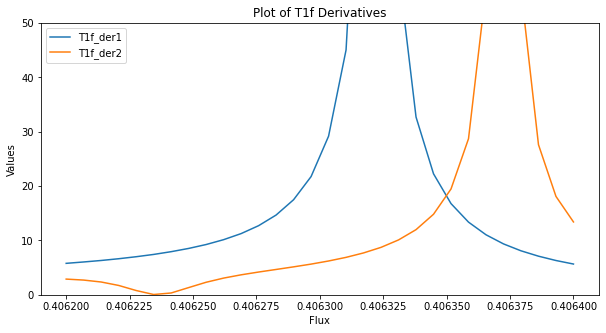

In [640]:
plt.figure(figsize=(10, 5))
plt.plot(flux_range, T1f_der1_values1, label='T1f_der1')
plt.plot(flux_range, T1f_der2_values1, label='T1f_der2')
plt.xlabel('Flux')
plt.ylabel('Values')
plt.title('Plot of T1f Derivatives')
plt.ylim(0,50)
plt.legend()
plt.show()

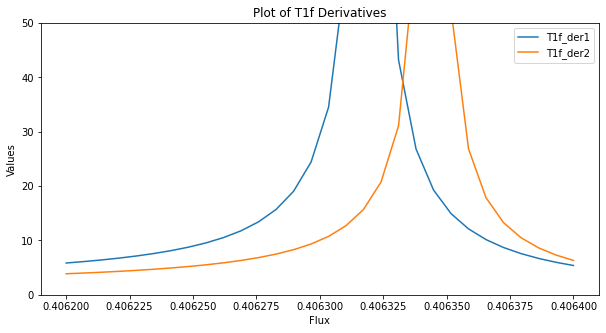

In [641]:
plt.figure(figsize=(10, 5))
plt.plot(flux_range, T1f_der1_values, label='T1f_der1')
plt.plot(flux_range, T1f_der2_values, label='T1f_der2')
plt.xlabel('Flux')
plt.ylabel('Values')
plt.title('Plot of T1f Derivatives')
plt.legend()
plt.ylim(0,50)
plt.show()

In [ ]:
T1f_der1_values

In [ ]:
T1f_der2_values